# Описание проекта

## Инструкция по выполнению проекта

1.	Загрузите данные и выполните их ресемплирование по одному часу.

2.	Проанализируйте данные.

3.	Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

4.	Проверьте данные на тестовой выборке и сделайте выводы.


## Описание данных

In [ ]:
#pip install lightgbm

## Загрузка данных и ресемплирование

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pandas_datareader import DataReader

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import tree

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import yfinance as yf

KeyboardInterrupt: 

In [ ]:
# Считаем данные
start = '2014-01-01'
end = '2024-10-12'
symbol = 'AMZN'
company = 'Amazon'
stock_data = yf.Ticker(symbol)
stock_data = stock_data.history(start=start, end=end)



In [ ]:
# Первые 5 строк датасета
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-02 00:00:00-05:00,19.940001,19.9680,19.701000,19.898500,42756000,0.0,0.0
2014-01-03 00:00:00-05:00,19.914499,20.1355,19.811001,19.822001,44204000,0.0,0.0
2014-01-06 00:00:00-05:00,19.792500,19.8500,19.421000,19.681499,63412000,0.0,0.0
2014-01-07 00:00:00-05:00,19.752001,19.9235,19.714500,19.901501,38320000,0.0,0.0
2014-01-08 00:00:00-05:00,19.923500,20.1500,19.802000,20.096001,46330000,0.0,0.0


In [ ]:
# Общая информация о датафрейме
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2014-01-02 00:00:00-05:00 to 2024-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2713 non-null   float64
 1   High          2713 non-null   float64
 2   Low           2713 non-null   float64
 3   Close         2713 non-null   float64
 4   Volume        2713 non-null   int64  
 5   Dividends     2713 non-null   float64
 6   Stock Splits  2713 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 169.6 KB


In [ ]:
# Отсортируем индексы в хронологическом порядке

stock_data.sort_index(inplace = True)
print('Минимальная дата', stock_data.index.min())
print('Максимальная дата', stock_data.index.max())

Минимальная дата 2014-01-02 00:00:00-05:00
Максимальная дата 2024-10-11 00:00:00-04:00


In [ ]:
# Удалим столбцы с объемом продаж, цене открытия, самой высокой и низкой ценой, дивидентах
stock_data.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis = 1, inplace = True)

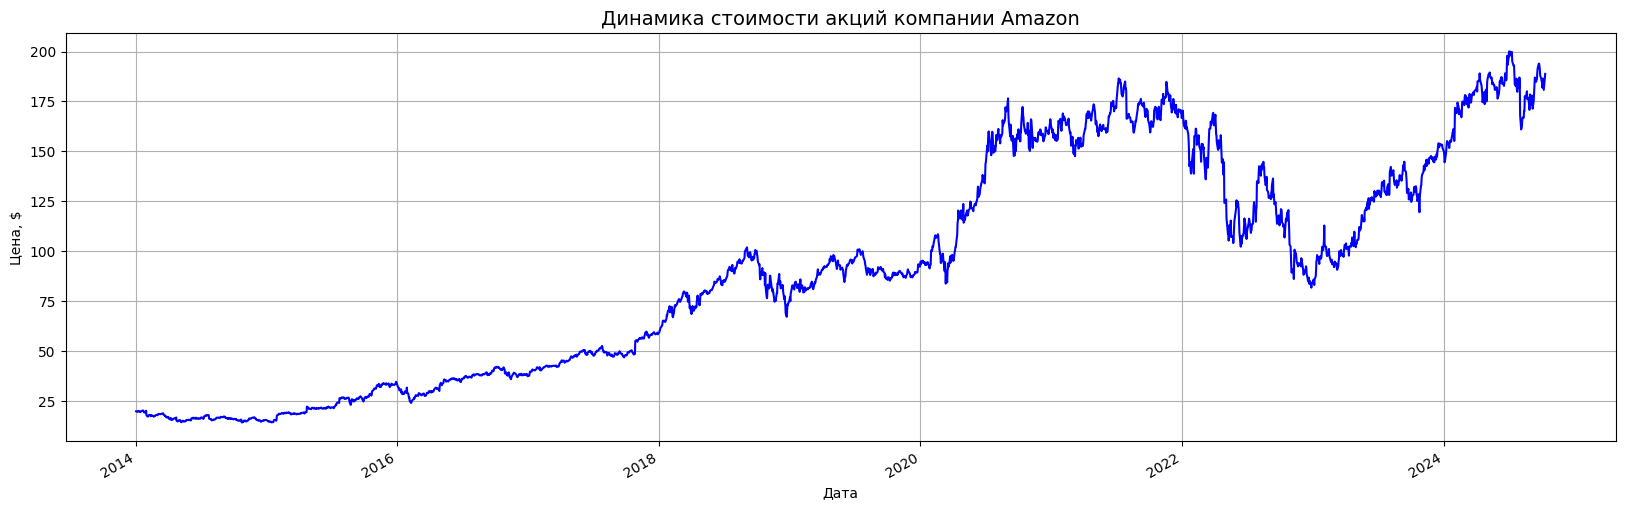

In [ ]:
# Построим график данных

stock_data['Close'].plot(color = 'blue', figsize=(20, 6))
plt.title('Динамика стоимости акций компании '+company, fontsize = 14)
plt.xlabel('Дата')
plt.ylabel('Цена, $')
#plt.legend(loc = 'best')
plt.grid()
plt.show()

**Ресемплирование**, или ресемплинг (англ. resample, «повторная выборка»), — это изменение интервала со значениями ряда.
Его выполняют в два этапа:
* Выбирают новую длину интервала. Причём значения из текущего интервала группируются. Допустим, интервал равен 10 минутам. Возьмём новый интервал — 30 минут. В него попадут значения из трёх 10-минутных интервалов.
* В каждой группе вычисляется агрегированное значение ряда. Это может быть медиана, среднее, максимум или минимум.

 Чтобы поменять интервал и сгруппировать значения, вызовем функцию `resample()`. В аргументе укажем новый интервал.
 Функция `resample()` похожа на `groupby()`. После группировки вызовем функции `mean()` и `max()` для агрегации значений

среднее по каждому часу
`data.resample('1H').mean()`

максимум по каждым двум неделям
`data.resample('2W').max() `

## Анализ данных

1. Сезонную компоненту для лучшего понимания природы сезонности стоит исследовать на коротком промежутке времени - подойдёт 5-7 суток. Для выполнения этого пункта стоит найти ответы на следующие вопросы:
    
- какова природа сезонности (часовая, суточная, дневная, недельная, месячная)?;
    
- в какие периоды (с учётом пункта выше) наблюдаются пики стоимости, а в какие - спады?;
    
- чем обсуловлена природа сезонности?.

2. Что видим на графике остатков? Тут можно сделать предположение о стационарности ряда: если остатки ведут себя стабильно и не показывают сильный разброс, можем сделать предположение о стационарности ряда, и наоборот - нестационарный ряд будет показывать на графике разброс.

3. Стоит оценить стационарность ряда и сделать об этом вывод. Сделать это можно с помощью сглаживания скользящим средним и последующей визуализацией сглаженного ряда на графике (отлично будет смотреться на графике исходного временного ряда как его дополнение) - это самый простой способ.
    
    В реальных же задачах с временными рядами, в особенности - с финансовыми данными или биржевыми котировками, график не всегда поможет достоверно оценить стационарность ряда. Поэтому для оценки стационарности ряда лучше использовать тест Дики — Фуллера (подробнее о нём можно глянуть тут: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html, он даст наиболее точный результат. Тест Дики-Фулллера стоит провести на нескольких уровнях значимости - 1% и 5%. Вдруг результаты будут отличаться?

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

**Тренд** (англ. trend) — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например, ежегодное увеличение объёма продаж авиабилетов.

**Сезонность** (англ. seasonality) — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.

Тренды и сезонность зависят от масштаба данных. Нельзя увидеть закономерности, повторяющиеся каждое лето, если есть данные только за год.


В модуле `tsa.seasonal` (от англ. time series analysis, «анализ временных рядов») библиотеки `statsmodels` (англ. «статистические модели») есть функция `seasonal_decompose()` (англ. «разбить на части»). Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals). Это компонента, которая не объясняется трендом и сезонностью, это шум.

Функция `seasonal_decompose()` принимает временной ряд, а возвращает объект структуры `DecomposeResult` (англ. «результат разделения»). В нём есть нужные атрибуты:
* `decomposed.trend` — тренд;
* `decomposed.seasonal` — сезонная составляющая;
* `decomposed.resid` — остаток декомпозиции.

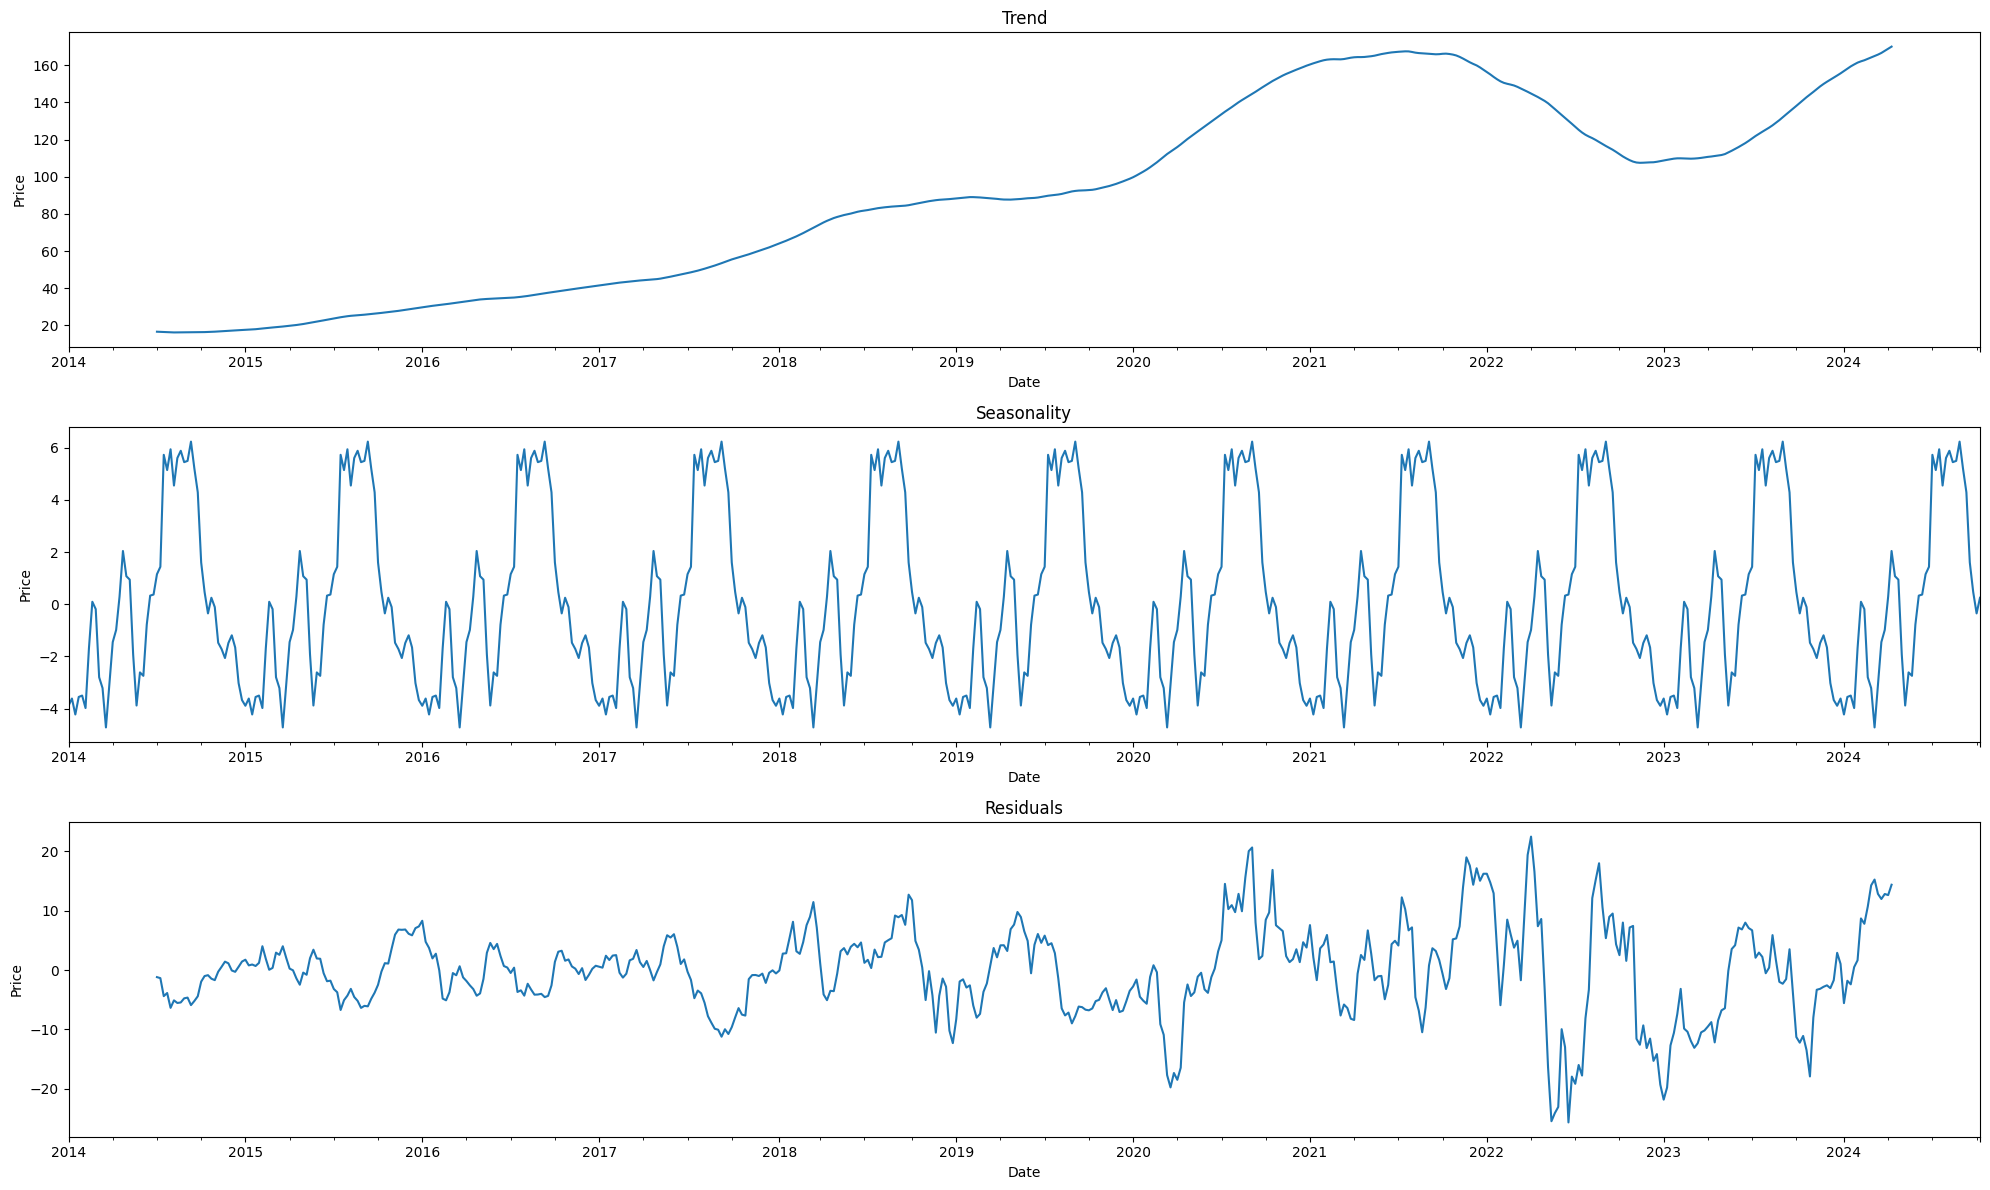

In [ ]:
#Рассмотрим недельные данные, выполним ресемплирование ряда по 1 неделе
df_week = stock_data.resample('1W').mean()

#Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df_week)


# Построим графики этих составляющих ряда
plt.figure(figsize=(20, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()

На недельных данных можем наблюдать линейный тренд, тенденцию к росту стоимости в течение рассматриваемого периода. Видим проявление сезонности на протяжении всего периода наблюдений. Амплитуда колебаний примерно одинаковая, что свидельствует об аддитивности модели временного ряда. Среднее значение ряда меняется, временной ряд не является стационарным.

К концу года наблюдаются большие колебания на часовых данных. Среднее значение ряда меняется, временной ряд не является стационарным. На графике остатков можем наблюдать б'ольшие отклонения с 2021 года, чем в другие периоды.

### Скользящее среднее

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

**Скользящее среднее** (англ. rolling mean), или движущееся среднее (англ. moving average), — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

Метод работает так: экспериментально подбирается размер окна (англ. `window size`) — интервал, в котором выполняют усреднение. Чем интервал больше, тем сильнее сглаживание. Затем окно начинает «скользить» почти от начала ряда к его концу, в каждой точке вычисляя среднее значение ряда и тем самым сглаживая его.

В скользящем среднем окна «наслаиваются» друг на друга и не могут выходить за пределы ряда. Поэтому средних будет чуть меньше, чем исходных значений ряда.

В `Pandas` скользящее среднее вычисляют в два этапа:
* Вызовом функции `rolling()` создают скользящее окно. В аргументе указывают его размер:
`data.rolling(7) ` (размер окна 7)
* Для агрегации значений вызывают функцию `mean()`:
`data.rolling(7).mean() ` (скользящее среднее с окном размером 7).


При использовании `.rolling()` скользящее среднее считается с учётом текущего шага - это не совсем верно для задачи временных рядов, так как будет работать только для известных нам значений и сломается на предсказаниях.
        
Нужно либо использовать `.shift()` перед `.rolling()`, либо параметру `closed` при использовании `.rolling()` передать значение `left`.


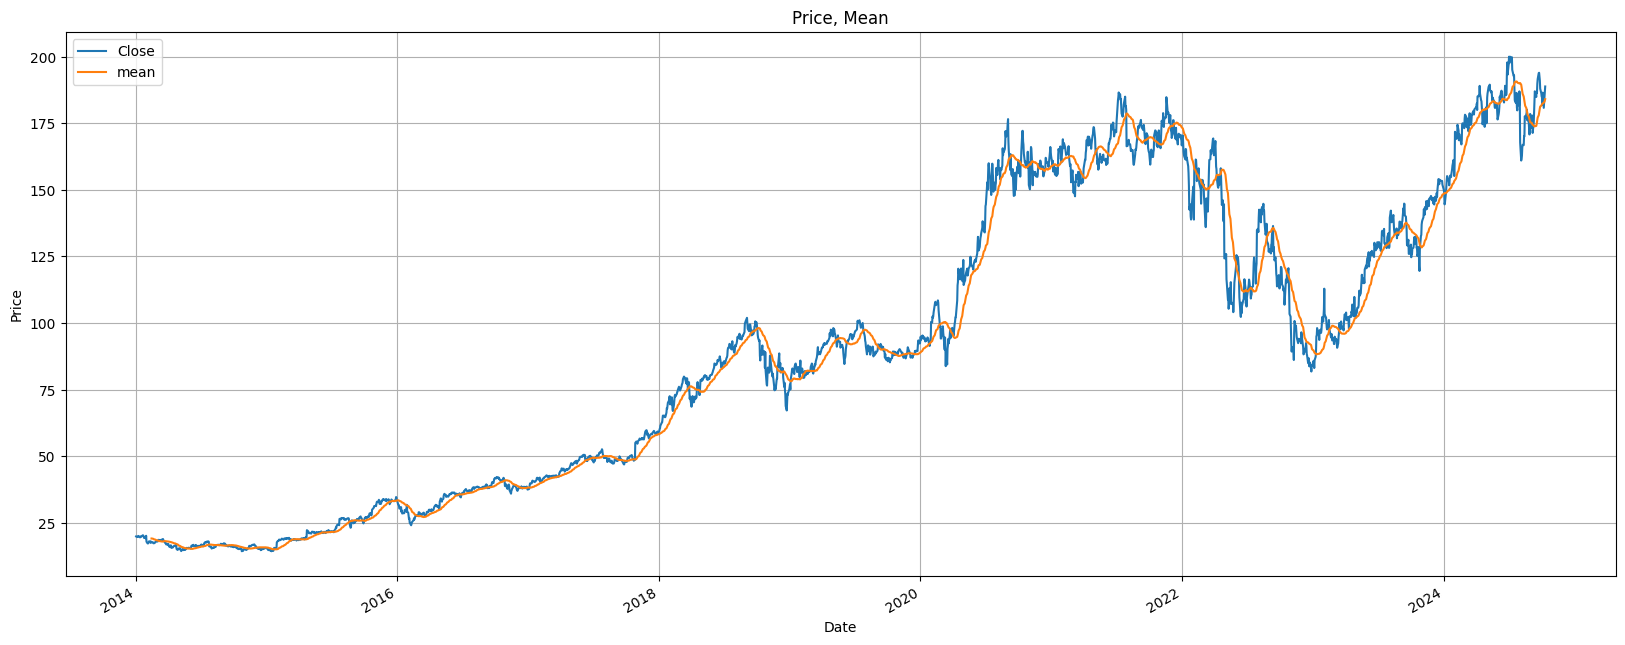

In [ ]:
# Найдем скользящее среднее по ширине окна 30 дней
stock_data['mean'] = stock_data.shift().rolling(30).mean()

# построим график цены и скользящего среднего
stock_data.plot(figsize=(20, 8))
plt.title('Price, Mean')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

### Стационарность временного ряда

Прогнозировать данные помогают стационарные ряды.

В статистике временной ряд описывается стохастическим процессом (англ. stochastic process). Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.
Стохастический процесс **стационарный** (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений.

Если распределение меняется, то процесс называется **нестационарным** (англ. nonstationary stochastic process).

Узнать распределение временного ряда нельзя. Поэтому стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.

Нестационарные ряды (англ. nonstationary time series) прогнозировать сложнее: их свойства меняются слишком быстро.


**Cкользящее стандартное отклонение** (англ. rolling standard deviation, rolling std) — стандартное отклонение по скользящему окну

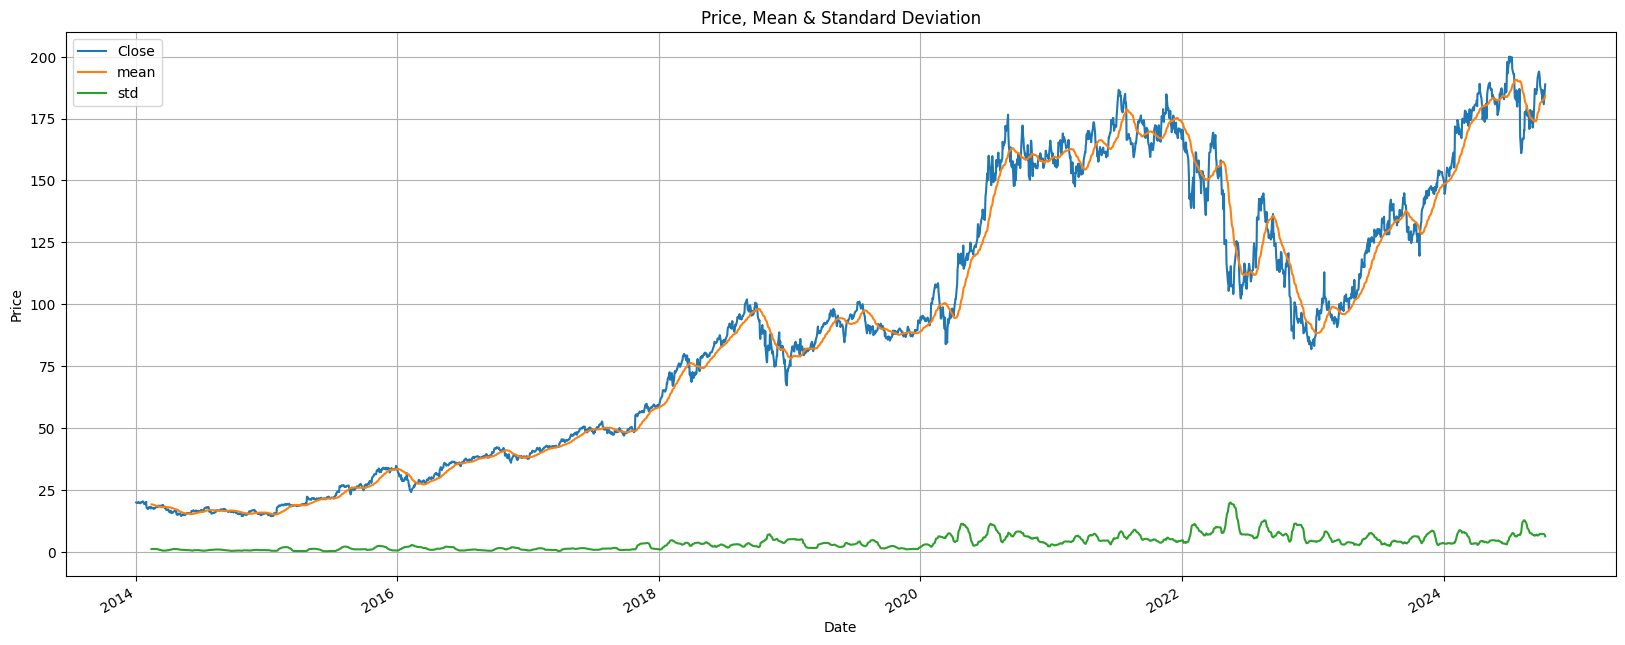

In [ ]:
# Найдем скользящее стандартное отклонение по ширине окна 30 дней
# и построим график исходного временного ряда, скользящего среднего и скользящего стандартного отклонения

stock_data['std'] = stock_data['Close'].shift().rolling(30).std()

stock_data.plot(figsize=(20, 8))
plt.title('Price, Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

Предположение о нестационарности ряда подтверждается.

### Разности временного ряда

Чтобы ряд сделать стационарным, найдём разности его значений.

**Разности временного ряда** (англ. time series difference) — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее.

Для поиска разностей временного ряда применяется метод `shift()` (англ. «сдвиг»). Все значения он сдвигает вдоль временной оси на один шаг вперёд.

Последнее значение ряда пропадает: его сдвигать некуда. На месте нулевого — `NaN`, потому что для него значения нет. Добавим аргумент, чтобы заполнить недостающие значения:
`data.shift(fill_value=0)`

Рассмотрим ряд первых разностей временного ряда и изобразим его скользящее среднее и скользящее стандартное отклонение.

In [ ]:
# ряд первых разностей временного ряда
df_shift =stock_data - stock_data.shift(fill_value=0)

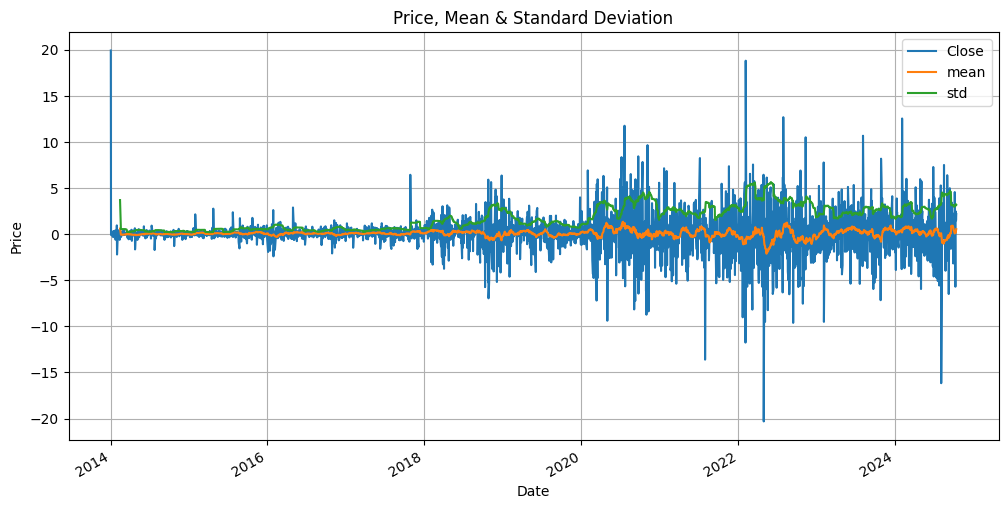

In [ ]:
#скользящее среднее и скользящее стандартное отклонение ряда первых разностей

df_shift['mean'] = df_shift['Close'].shift().rolling(30).mean()
df_shift['std'] = df_shift['Close'].shift().rolling(30).std()

# график первых разностей временного ряда, его скользящего среднего
# и скользящего стандартного отклонения
df_shift.plot(figsize=(12, 6))
plt.title('Price, Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

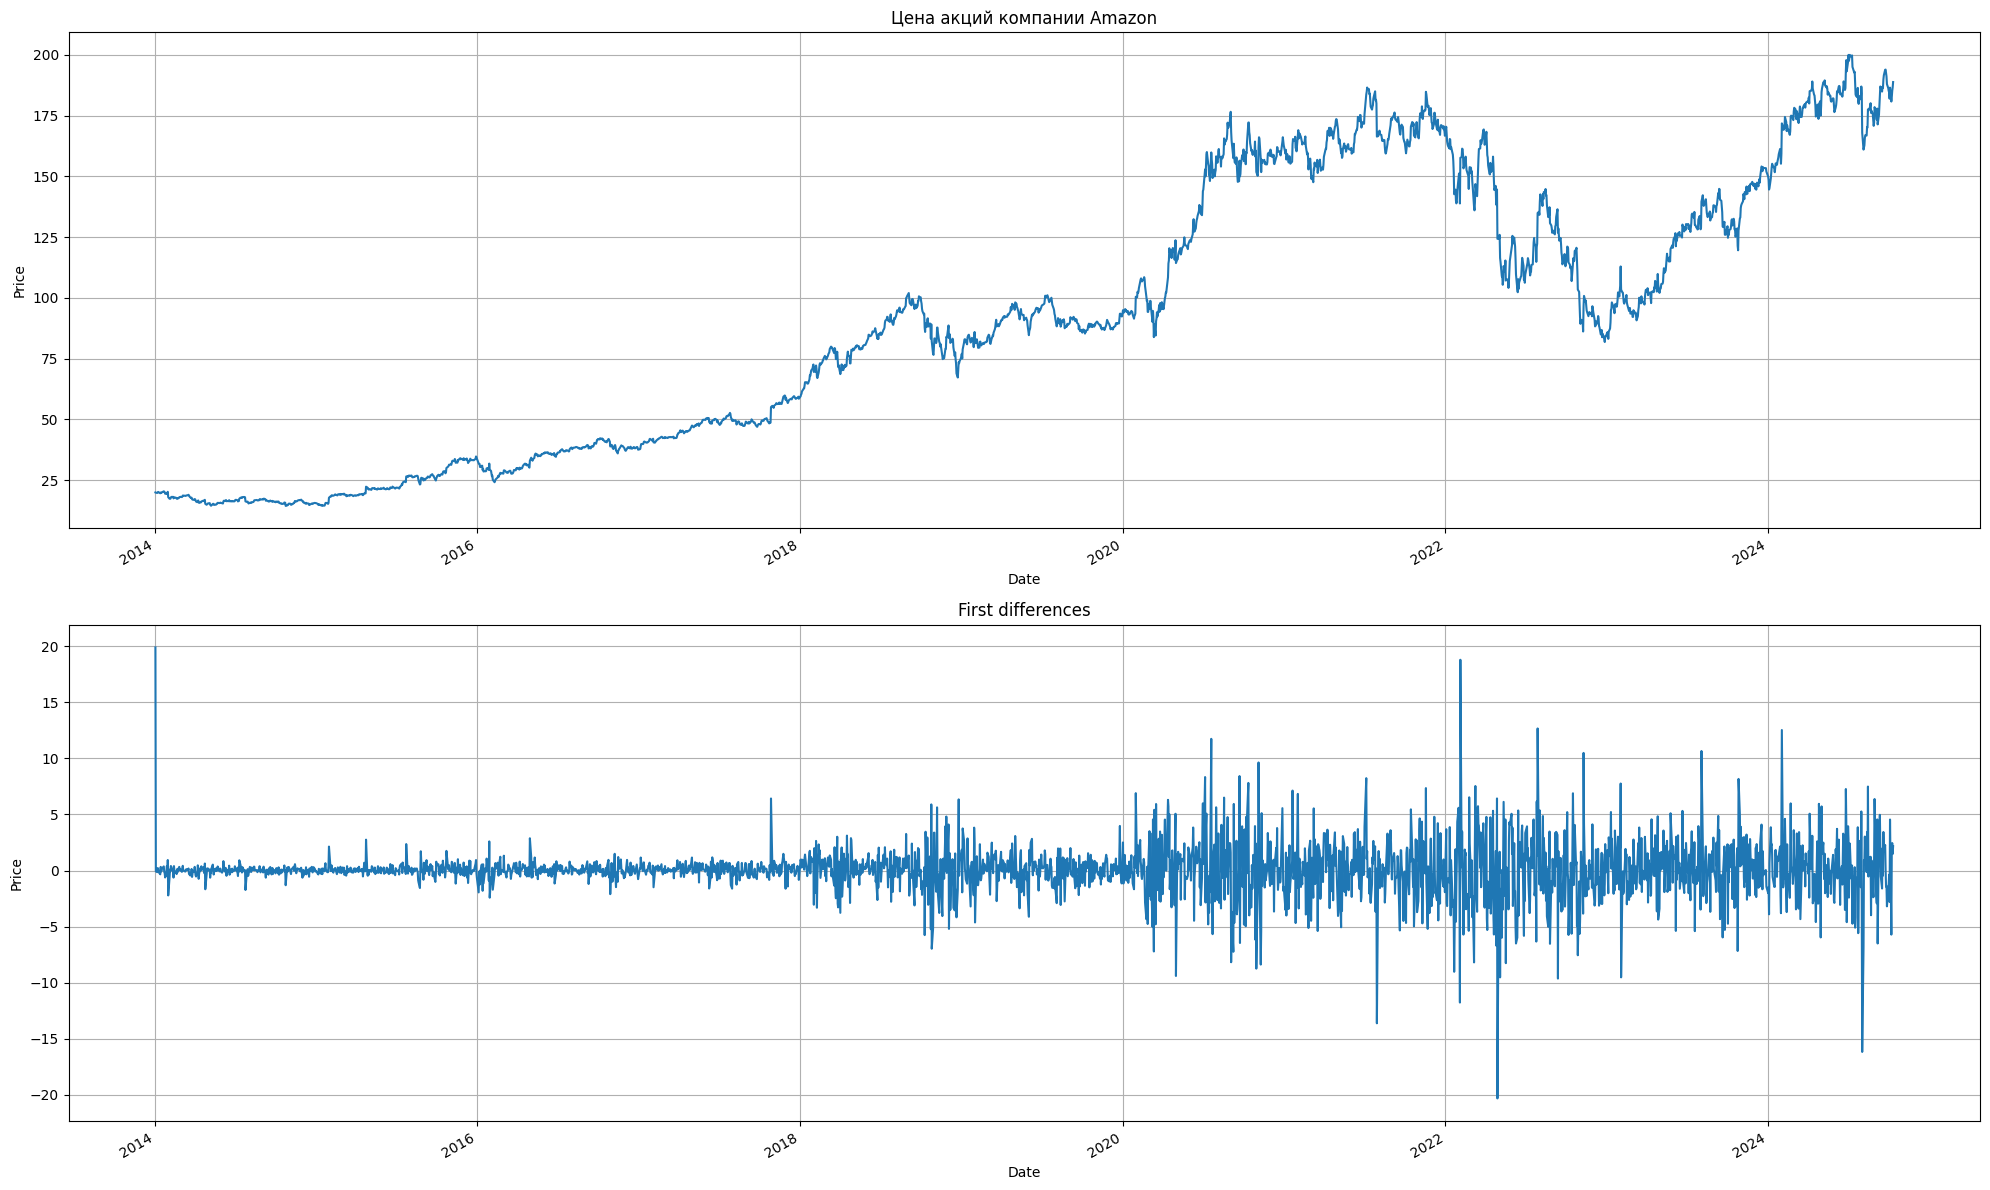

In [ ]:
# Построим графики исходного временного ряда и его первых разностей
plt.figure(figsize=(20, 12))
plt.subplot(211)
stock_data['Close'].plot(ax=plt.gca())
plt.title('Цена акций компании '+company)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.subplot(212)
df_shift['Close'].plot(ax=plt.gca())
plt.title('First differences')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

plt.tight_layout()

Ряд первых разностей более стационарный.

Исследуем ряд на стационарность. Построим автокорреляционную функцию и проведем тест Дики-Фуллера.


<Figure size 2400x1200 with 0 Axes>

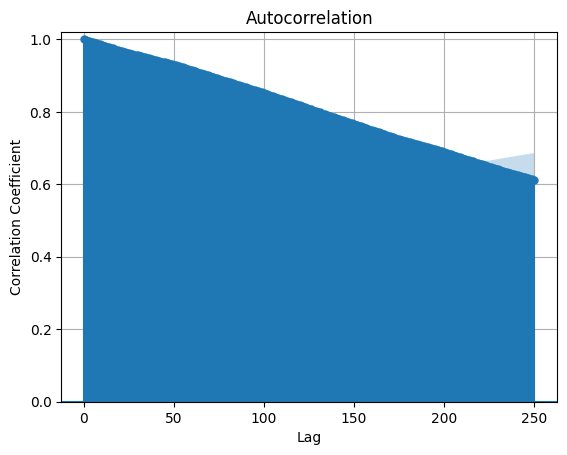

In [ ]:
#График автокорреляционной функции при лаге 250
plt.figure(figsize=(24, 12))
plot_acf(stock_data["Close"], lags = 250)
plt.xlabel('Lag')
plt.ylabel('Сorrelation Сoefficient')
#plt.xlim([0, 100.02])
plt.ylim([0, 1.02])
plt.grid()
plt.show()

<Figure size 2400x1200 with 0 Axes>

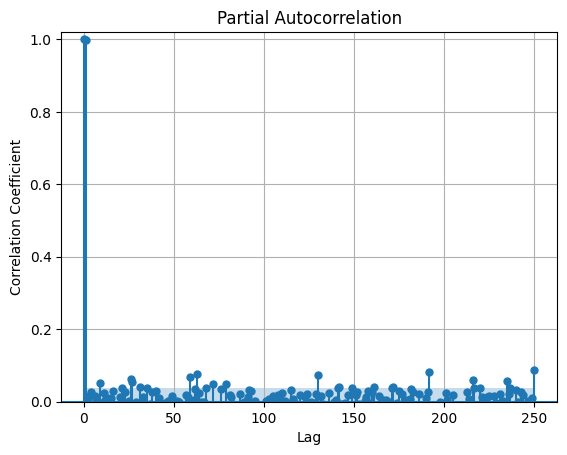

In [ ]:
#График частной автокорреляционной функции при лаге 250
plt.figure(figsize=(24, 12))
plot_pacf(stock_data["Close"], lags = 250, method='ols')
plt.xlabel('Lag')
plt.ylabel('Сorrelation Сoefficient')
#plt.xlim([0, 100.02])
plt.ylim([0, 1.02])
plt.grid()
plt.show()

Наибольшее значение коэффициента корреляции соответствует лагу 1, что подтверждает предположение о линейном тренде. По графику автокорреляционной функции видим отсутствие проявления сезонной компоненты.

Критерий Дики-Фуллера называют тестом на наличие единичного корня.

Суть тестов заключается в следующем:
* делается предположение о виде процесса, породившего данный временной ряд;
строится вспомогательная модель и проверяются гипотезы о коэффициентах этой модели;
* делается вывод о стационарности/ нестационарности исходного ряда.

Сложность заключается
* в корректности предположения о виде вспомогательной модели;
* в небольшой мощности теста для временных рядов с менее чем 100 наблюдениями.

Версии теста в `statsmodels` задаются параметром `regression`:
* «c»: только константа (по умолчанию)
* «ct»: константа и тенденция
* «ctt»: постоянный, линейный и квадратичный тренд
* «n»: нет константы, нет тенденции



In [ ]:
# Проведем тест Дики-Фуллера
test = adfuller(stock_data["Close"])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен при 5% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 5% уровне значимости')

if test[0]> test[4]['1%']:
    print('есть единичные корни, ряд не стационарен при 1% уровне значимости')
else:
    print('единичных корней нет, ряд стационарен при 1% уровне значимости')

adf:  -0.4604304080907586
p-value:  0.8995096934578897
Critical values:  {'1%': -3.432787825991557, '5%': -2.8626170511965543, '10%': -2.567343350533518}
есть единичные корни, ряд не стационарен при 5% уровне значимости
есть единичные корни, ряд не стационарен при 1% уровне значимости


### Создание новых признаков

Создадим признаки для горизонта прогнозирования в один шаг.
Разберём каждый тип признаков:
1. **Календарные признаки (англ. calendar features)**

Во многих данных тренды и сезонность привязаны к конкретной дате. Тип `datetime64` в `Pandas` уже содержит нужную информацию, осталось лишь представить её как отдельные столбцы.

Например:

`data = pd.read_csv('filename.csv', index_col=[0], parse_dates=[0])`

`data.sort_index(inplace=True)`

`data = data.resample('1D').sum()`

признак, в котором хранится год как число `data['year'] = data.index.year`

признак, в котором хранится день недели как число `data['dayofweek'] = data.index.dayofweek`

2. **«Отстающие значения» (англ. lag features)**

Предыдущие значения временного ряда подскажут, будет ли функция `x(t)` расти или уменьшаться. Получим отстающие значения знакомой функцией `shift()`:

`data['lag_1'] = data['num_orders'].shift(1)`

`data['lag_2'] = data['num_orders'].shift(2)`

`data['lag_3'] = data['num_orders'].shift(3)`

Для первых дат есть не все отстающие значения, поэтому в этих строках стоят `NaN`.

3. **Скользящее среднее**

Скользящее среднее как признак задаёт общий тренд временного ряда. Повторим, как его вычислять:
`data['rolling_mean'] = data['column_name'].rolling(5).mean()`.

Скользящее среднее в моменте `t` учитывает текущее значение ряда `x(t)`. Это некорректно: целевой признак «убежал» в признаки. Вычисление скользящего среднего не должно включать в себя текущее значение ряда.

Для построения моделей прогнозирования числа заказов сформируем новые признаки. Т.к. данные представлены за период меньше 1 года, то год как признак учитывать нет необходимости, он для всех уровней ряда одинаков.

В нашем датасете данные только за неполный год и так как данные отстортированы по возрастанию даты, модель сможет работать адекватно только с теми значениями месяца, которые были на обучающей выборке. В оперативных данных таких значений месяца не будет, и модель не сможет работать с ними корректно. Поэтому признак месяц использовать тоже будет не совсем корректно.

Будем учитывать следующие календарные признаки: день, день недели; лаговые значения и скользящее среднее.


Для формирования признаков напишем функцию, которая добавит соответствующие столбцы в исходный датасет.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    data_new['month'] = data.index.month

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['Close'].shift(lag)

    data_new['rolling_mean'] = data_new['Close'].shift().rolling(rolling_mean_size).mean()
    return data_new

Определите самостоятельно величину лага и ширину окна сглаживания для формирования новых признаков.

In [ ]:
# Включим в модель значения с лагом 14 и скользящее среднее по ширине окна 30.
# Применим функцию make_features и создадим новый датасет df_new
df_new = make_features(stock_data, max_lag = 14, rolling_mean_size = 30)
df_new.head(10)

,Close,mean,std,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,19.898500,NaN,NaN,2,3,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03 00:00:00-05:00,19.822001,NaN,NaN,3,4,1,19.898500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06 00:00:00-05:00,19.681499,NaN,NaN,6,0,1,19.822001,19.898500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07 00:00:00-05:00,19.901501,NaN,NaN,7,1,1,19.681499,19.822001,19.898500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08 00:00:00-05:00,20.096001,NaN,NaN,8,2,1,19.901501,19.681499,19.822001,19.898500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-09 00:00:00-05:00,20.050501,NaN,NaN,9,3,1,20.096001,19.901501,19.681499,19.822001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-10 00:00:00-05:00,19.882999,NaN,NaN,10,4,1,20.050501,20.096001,19.901501,19.681499,...,19.898500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-13 00:00:00-05:00,19.549000,NaN,NaN,13,0,1,19.882999,20.050501,20.096001,19.901501,...,19.822001,19.898500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-14 00:00:00-05:00,19.877001,NaN,NaN,14,1,1,19.549000,19.882999,20.050501,20.096001,...,19.681499,19.822001,19.898500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Удалим столбцы 'mean', 'std', которые были ранее добавлены для посторения графиков.
df_new.drop(['mean', 'std'], axis=1, inplace= True)

По исходным данным создадим обучающую (`train`) и тестовую (`test`) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

Функция `train_test_split()` из модуля `sklearn.model_selection` по умолчанию перемешивает данные. Поэтому укажем аргумент `shuffle` (с англ. «перетасовывать») равным `False`, чтобы разделить данные корректно


Разделим данные на обучающую и тестовую выборки. Отстающие значения и скользящее среднее вычисляются по прошлым данным.

Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.

Получить признаки для первых значений обучающей выборки нельзя: исторических данных по ним нет. Значения этих признаков были `NaN`. Их нужно удалить.

In [ ]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)  #shuffle=False обязательно чтобы данные не перемешались
train = train.dropna()

print(train.shape)

print(test.shape)
print(train.index.min(), train.index.max())

print(test.index.min(), test.index.max())

(2411, 19)
(272, 19)
2014-02-14 00:00:00-05:00 2023-09-13 00:00:00-04:00
2023-09-14 00:00:00-04:00 2024-10-11 00:00:00-04:00


Выделим целевой признак

In [ ]:
X_train = train.drop(['Close'], axis=1)
y_train = train['Close']

X_test = test.drop(['Close'], axis=1)
y_test = test['Close']

In [ ]:
y_test

,Close
Date,
2023-09-14 00:00:00-04:00,144.720001
2023-09-15 00:00:00-04:00,140.389999
2023-09-18 00:00:00-04:00,139.979996
2023-09-19 00:00:00-04:00,137.630005
2023-09-20 00:00:00-04:00,135.289993
...,...
2024-10-07 00:00:00-04:00,180.800003
2024-10-08 00:00:00-04:00,182.720001
2024-10-09 00:00:00-04:00,185.169998


In [ ]:
# Стандартизируем данные
scaler = StandardScaler()   #переводим для удобства интерпертации коэффициентов линейной регресси
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)


Чтобы проверять качество моделей в наших задачах, возьмём, например, метрику `MAE`. Её можно легко интерпретировать.

Спрогнозировать временные ряды без обучения можно двумя способами:
* Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики `MAE` — это медиана.
* Новое значение `x(t)` прогнозируется предыдущим значением ряда, то есть `x(t-1)`. Этот способ не зависит от метрики.

## Обучение моделей

Гиперпараметры — это настройки алгоритмов обучения. В отличие от параметров, их задают перед процессом обучения.

В решающем дереве, например, это максимальная глубина или выбор критерия — Джини либо энтропийного (о нём расскажем позже). Гиперпараметры помогают улучшить модель. Изменить их можно до начала обучения.


Таким образом, параметры не устанавливают, а вычисляют на основе данных модели. А гиперпараметры, напротив, подбирают и задают вручную перед запуском обучения.

Для подбора гиперпараметров моделей будем проводить кросс-валидацию. Кросс-валидация может быть нужна в случаях, если данных мало или мы не хотим зависеть от конкретного выбора валидационного множества.

Примерный алгоритм:
* зафиксировать некоторое тестовое множество и отложить его;  
* разделить оставшееся множество данных на фолдов (подмножеств), пройтись по ним циклом, на каждой итерации фиксируя один фолд в качестве валидационного и обучаясь на остальных;
* в качестве оценки качества модели взять среднее значение валидационной метрики по фолдам;
* финальное сравнение моделей с уже подобранными гиперпараметрами проводить на отложенном тестовом множестве.

Правильным решением будет использование специального инструмента библиотеки `sklearn` для кросс-валидации временных рядов `TimeSeriesSplit` (подробнее тут: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Он формирует фолды так, чтобы в фолдах для обучения не было данных из фолдов для тестирования, что критически важно при работе с временными рядами. Экземпляр этого валидатора нужно будет передать в параметр `cv` при использовании `GridSearchCV`.

Также рекомендую почитать статью о сплитовании для временных рядов - даст понимание, как работает `TimeSeriesSplit`: https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9.

То же касается и `cross_val_score` для линейной регрессии, когда параметры при кросс-валидации не подбираются.

Кросс-валидация моделей для временного ряда осложняется тем, что данные не должны пересекаться по времени: тренировочные данные должны идти до валидационных, а валидационные — до тестовых. С учётом этих особенностей фолды в кросс-валидации для временных рядов располагаются вдоль временной оси так, как показано на картинке:


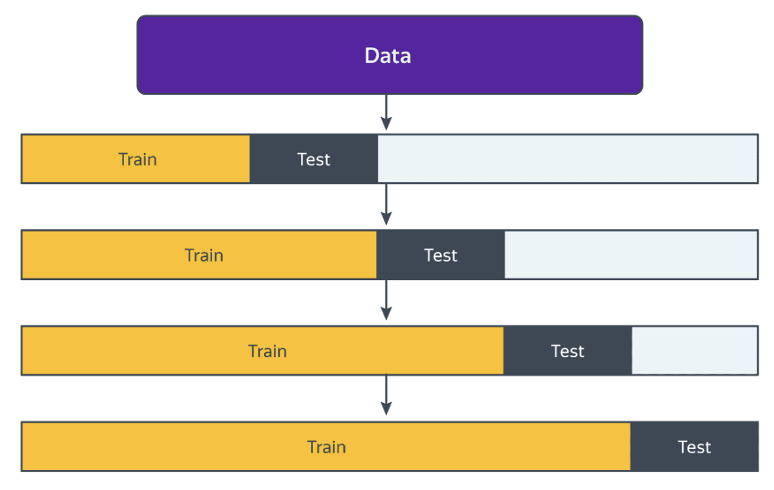

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке (`Grid Search`):

* для каждого гиперпараметра фиксируется несколько значений;
* перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
* выбирается комбинация, на которой модель показывает лучшее качество.

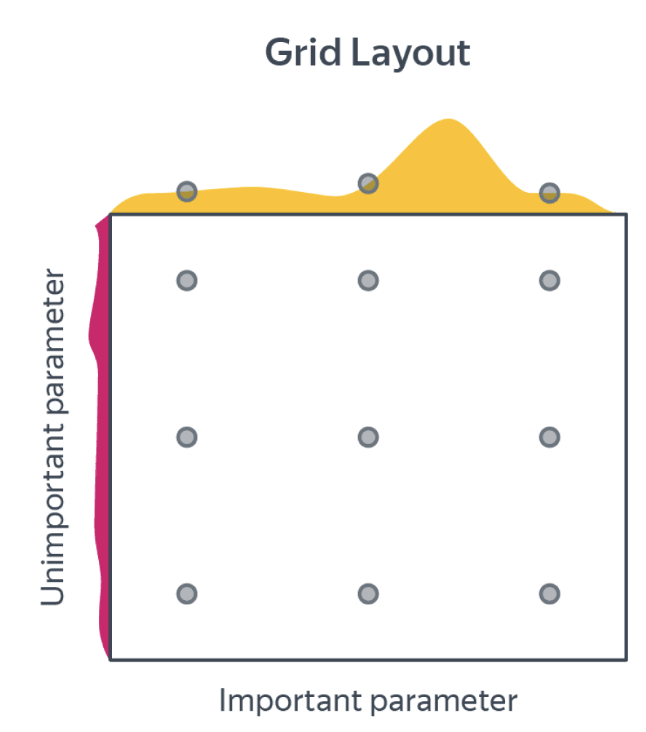

In [ ]:
# Словать с метриками для обучения моделей
scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

In [ ]:
# Определяем тип кросс-валидаци на временных рядах
tscv = TimeSeriesSplit(n_splits=6)

## Задание для самостоятельной работы

Выберите для прогнозирования стоимости акций ту же компанию, что и в задании 6 (прогнозирование с помощью моделей рекуррентных нейронных сетей) за аналогичный период. Выберите самостоятельно наиболее подходящие признаки, на основе которых стоите прогноз с помощью моделей ML, аргументируйте свой выбор. Постройте не менее трех различных моделей ML. Определите оптимальные гиперпараметры выбранных моделей. Оцените качество всех построенных моделей на валидационной выборке и выберите лучшую модель. Постройте прогноз на тестовой выборке "лучшей" моделью. Оцените результат. Сравните результат построения прогноза классическими моделями ML с результатом, полученном при прогнозировании моделями GRU и LSTM. Сделайте вывод о целесообразности применения классических алгоритмов ML для прогнозирования временных рядов.

### Linear Regression

In [ ]:
# Метрики
start = time.time()
lr=LinearRegression()
lr.fit(X_train,y_train)
end = time.time() - start
pred = lr.predict(X_test)
print("MSE валидационной выборки:", mean_squared_error(y_test, pred))
print("RMSE валидационной выборки:", np.sqrt(mean_squared_error(y_test, pred)))
print("MAE валидационной выборки:", mean_absolute_error(y_test, pred))
print("MAPE валидационной выборки:", mean_absolute_percentage_error(y_test, pred))
print(end)

MSE валидационной выборки: 8.72797954019378
RMSE валидационной выборки: 2.95431540973434
MAE валидационной выборки: 2.1906197851913056
MAPE валидационной выборки: 0.013286863295847218
0.023897886276245117


### ElasticNet

In [ ]:
# Используем GridSearch для подбора гиперпараметров модели
param_grid = {}

In [ ]:
Elastic = GridSearchCV(ElasticNet(random_state=12345), param_grid, cv=tscv, scoring='neg_root_mean_squared_error').fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.755e+03, tolerance: 6.005e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+03, tolerance: 7.643e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

In [ ]:
print('Параметры лучшей модели', )
print('RMSE  лучшей модели', )

Параметры лучшей модели {'l1_ratio': 1}
RMSE  лучшей модели 12.81979587585859


### Decision Tree

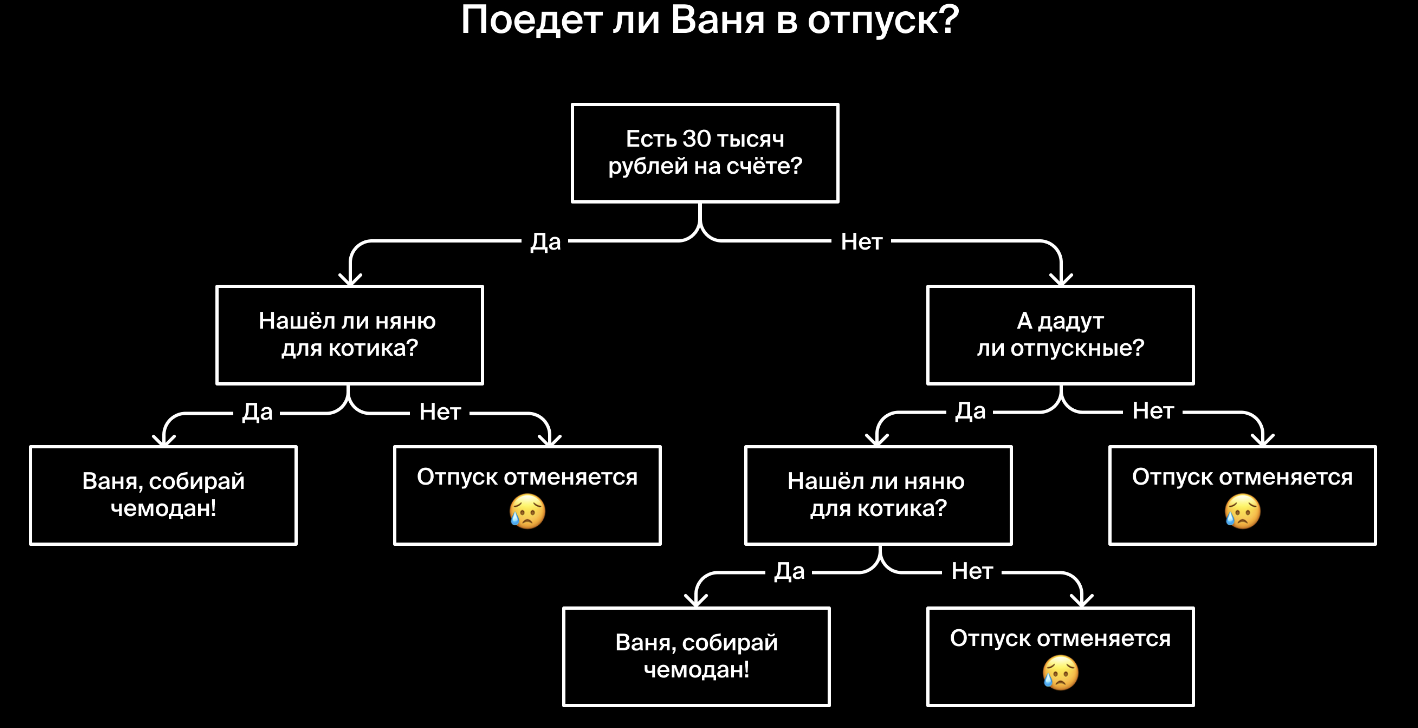


Как глубина дерева влияет на баланс между переобучением и недообучением? Глубина дерева (высота дерева) — это максимальное количество условий от «вершины» до финального ответа. Считается по количеству переходов между узлами.

Если дерево высокое, у модели склонность к переобучению; низкое — к недообучению.

Глубина дерева в `sklearn` задаётся параметром `max_depth` (англ. «максимальная глубина»)

In [ ]:
tree1=DecisionTreeRegressor()
parameters = {'max_depth':range(4,10,1),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10)
             }
dt=GridSearchCV(
    tree1,
    parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scoring,
    refit='rmse'
)
dt.fit(X_train,y_train)
print('Гиперпараметры',dt.best_params_ )
print('RMSE  лучшей модели', -dt.best_score_)
print('MSE', -dt.cv_results_['mean_test_mse'][dt.best_index_])
print('MAE',  -dt.cv_results_['mean_test_mae'][dt.best_index_])
print('MAPE', - dt.cv_results_['mean_test_mape'][dt.best_index_])

Гиперпараметры {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5}
RMSE  лучшей модели 13.958141812744424
MSE 304.07040187271247
MAE 10.401043053717054
MAPE 0.13331345887524965


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
from sklearn.tree import plot_tree

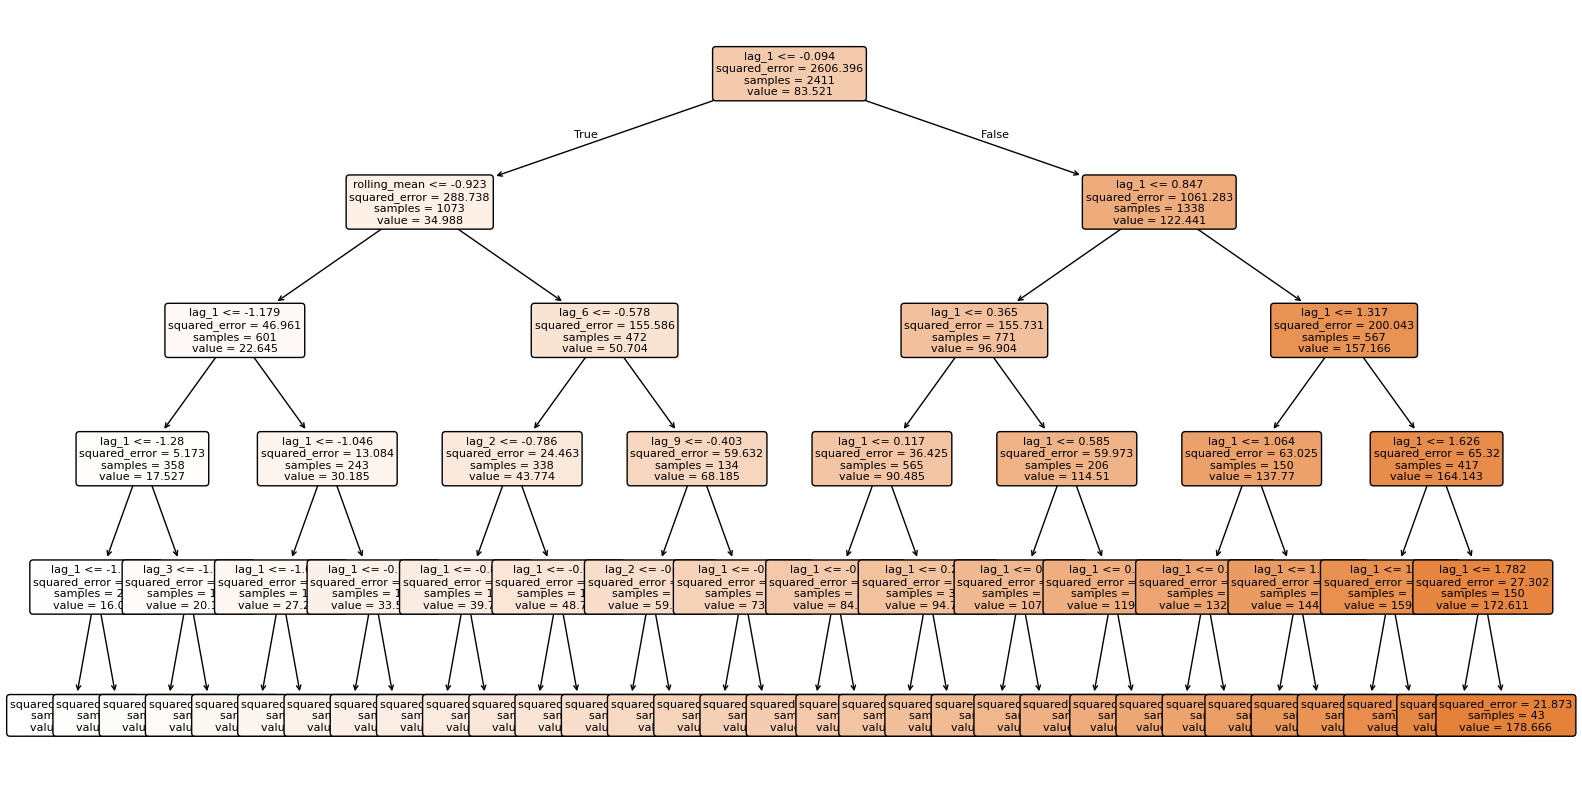

In [ ]:
# добавляем размер графика
plt.figure(figsize=(16, 8))

# визуализируйте модель дерева решений, отобразите названия признаков
# и раскрасьте узлы

plot_tree(decision_tree=dt.best_estimator_, feature_names=X_train.columns, filled=True, rounded = True, fontsize=8);
plt.tight_layout()
plt.show()

In [ ]:
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':dt.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False).head(10)
feature_imp

,Признак,Важность
3,lag_1,0.955431
17,rolling_mean,0.033199
8,lag_6,0.009119
4,lag_2,0.001142
11,lag_9,0.001067
5,lag_3,0.000042
16,lag_14,0.000000
15,lag_13,0.000000
14,lag_12,0.000000
13,lag_11,0.000000


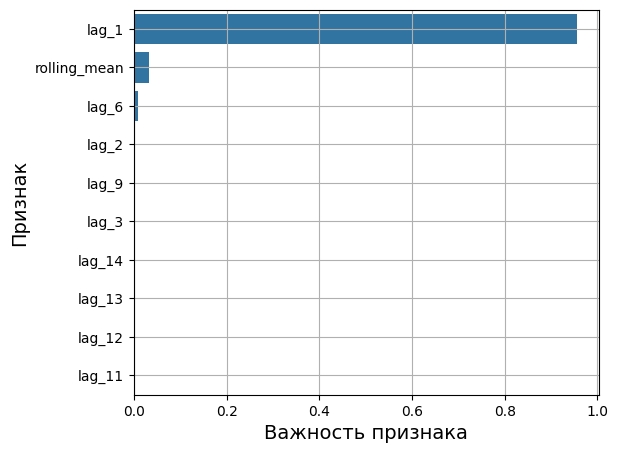

In [ ]:
# Визуализируем коэффициенты признаков
# добавляем размер графика
plt.figure(figsize=(6, 5))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])
plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

### K-ближайших соседей

Подберем лучшие значения гиперпараметров.

Создайте словарь со значениями гиперпараметров:
* `'n_neighbors'` в диапазоне от 3 до 14 нечетным значениям;
*  `'weights'` из списка ['uniform', 'distance'].


Инициализируйте класс `GridSearchCV`. В качестве значения кросс-валидации укажите `cvs`, также передайте метрику `fnr_score` и `n_jobs=-1`.

Запустите поиск гиперпараметров.

In [ ]:
# инициализируем модель k ближайших соседей
mod=KNeighborsRegressor()

# Создайте словарь со значением гиперпараметров:

parameters = {'n_neighbors': range(1,8,2),
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
             }

# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации tcvs, метрика rmse и n_jobs=-1.
KNN=GridSearchCV(
    mod,
    parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scoring,
    refit='rmse'
)
KNN.fit(X_train,y_train)

# выведите лучшие гиперпараметры
print('Гиперпараметры',KNN.best_params_ )
# выведите лучшую метрику качества


print('RMSE  лучшей модели', -KNN.best_score_)
print('MSE', -KNN.cv_results_['mean_test_mse'][KNN.best_index_])
print('MAE',  -KNN.cv_results_['mean_test_mae'][KNN.best_index_])
print('MAPE', - KNN.cv_results_['mean_test_mape'][KNN.best_index_])

Гиперпараметры {'algorithm': 'auto', 'n_neighbors': 5}
RMSE  лучшей модели 17.37338208966769
MSE 398.00633495721445
MAE 13.992394782406414
MAPE 0.1867434685015383


### Метод опорных векторов

In [ ]:
# инициализируем модель SVC
model=SVR()

# Создайте словарь со значением гиперпараметров:

parameters = {'kernel': ['rbf','sigmoid','poly','linear'],
              'C':[0.5,1.0,1.5]
             }

# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации tscv, метрика rmse и n_jobs=-1.
svr=GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scoring,
    refit='rmse'
)
svr.fit(X_train,y_train)

# выведите лучшие гиперпараметры
print('Гиперпараметры',svr.best_params_ )


# выведите лучшую метрику качества

print('RMSE  лучшей модели', -svr.best_score_)
print('MSE', -svr.cv_results_['mean_test_mse'][svr.best_index_])
print('MAE',  -svr.cv_results_['mean_test_mae'][svr.best_index_])
print('MAPE', - svr.cv_results_['mean_test_mape'][svr.best_index_])

Гиперпараметры {'C': 1.5, 'kernel': 'linear'}
RMSE  лучшей модели 2.44762040599212
MSE 6.880877875262331
MAE 1.817211111659132
MAPE 0.021192918026706822


### Random Forest

Попробуем новый алгоритм — случайный лес (англ. `random forest`). Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

Чтобы управлять количеством деревьев в лесу, пропишем гиперпараметр `n_estimators` (от англ. `number of estimators`, «количество оценщиков»). Чем больше деревьев, тем дольше модель будет учиться, но результат станет лучше (и наоборот).

In [ ]:
# Определим набор гиперпараметров для кросс-валидации и используем RandomizedSearch для их подбора
rfr=RandomForestRegressor()

parameters = {'min_samples_split': range(2, 6),
    'min_samples_leaf': range(4, 10),
    'max_depth': range(4, 10)

}
rantree=GridSearchCV(
    rfr,
    parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scoring,
    refit='rmse'
)
rantree.fit(X_train,y_train)
print('Гиперпараметры',rantree.best_params_ )
print('RMSE  лучшей модели', -rantree.best_score_)
print('MSE', -rantree.cv_results_['mean_test_mse'][rantree.best_index_])
print('MAE',  -rantree.cv_results_['mean_test_mae'][rantree.best_index_])
print('MAPE', - rantree.cv_results_['mean_test_mape'][rantree.best_index_])

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Гиперпараметры {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}
RMSE  лучшей модели 14.176341921915535
MSE 310.54777792346795
MAE 10.522000498940255
MAPE 0.13428108338654834


In [ ]:
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':rantree.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False).head(10)
feature_imp

,Признак,Важность
3,lag_1,0.960289
4,lag_2,0.021721
17,rolling_mean,0.012467
5,lag_3,0.001513
9,lag_7,0.000764
8,lag_6,0.000633
6,lag_4,0.000556
7,lag_5,0.000531
11,lag_9,0.000519
10,lag_8,0.000383


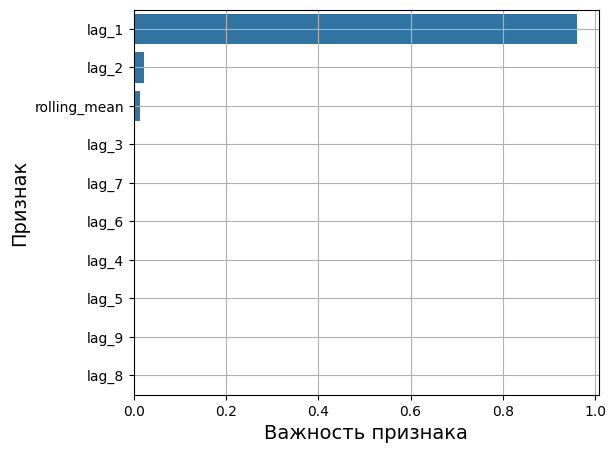

In [ ]:
# Визуализируем коэффициенты признаков
# добавляем размер графика
plt.figure(figsize=(6, 5))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])
plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

### LGBM_Regressor

Вы уже знакомы с одним типом ансамблевых моделей — случайным лесом. В нём усредняются результаты базовых моделей, или слабых классификаторов (англ. `base, weak classifier`) — моделей, из которых состоит ансамбль. Базовые модели в случайном лесе — это решающие деревья.

Второй подход к построению ансамблей — бустинг (англ. `boosting`). В нём каждая последующая модель учитывает ошибки предыдущей, а в финальном предсказании — прогнозы, построенные базовыми моделями.

Каждая базовая модель в бустинге старается «сдвинуть» предсказания прошлого шага в сторону правильных ответов. Так минимизируют функцию потерь. Градиентный спуск помогает делать это эффективнее.

Уменьшить переобучение градиентного бустинга поможет регуляризация.

Если в линейной регрессии снижали веса, то регуляризация для градиентного бустинга — это:
* уменьшение размера шага;
* настройка параметров деревьев;
* рандомизация подвыборок у базовых моделей `bᵢ`.

Значение размера шага подбирается экспериментально в диапазоне от 0 до 1. Чем меньше его значение, тем меньше шаг в сторону антиградиента и выше точность ансамбля. Но если значение шага слишком низкое, обучение будет идти медленно.

`LightGBM` (от англ. `light gradient boosting machine`; «лёгкая машина градиентного бустинга»). Разработка компании `Microsoft`, быстро и точно обучает градиентный бустинг. Работает с категориальными признаками напрямую.

In [ ]:
model2 =LGBMRegressor()
parameters = {'max_depth':range(8,12),
              'n_estimators': [ 100,150, 200],
              'learning_rate' : [0.05, 0.1, 0.15]
}
lgbm=GridSearchCV(
    model2,
    parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scoring,
    refit='rmse'
)
lgbm.fit(X_train,y_train)
print('Гиперпараметры',lgbm.best_params_ )
print('RMSE  лучшей модели', -lgbm.best_score_)
print('MSE', -lgbm.cv_results_['mean_test_mse'][lgbm.best_index_])
print('MAE',  -lgbm.cv_results_['mean_test_mae'][lgbm.best_index_])
print('MAPE', - lgbm.cv_results_['mean_test_mape'][lgbm.best_index_])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 2411, number of used features: 18
[LightGBM] [Info] Start training from score 83.520648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':lgbm.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False).head(10)
feature_imp

,Признак,Важность
3,lag_1,583
4,lag_2,175
17,rolling_mean,174
16,lag_14,162
15,lag_13,153
0,day,145
5,lag_3,121
14,lag_12,120
6,lag_4,119
8,lag_6,106


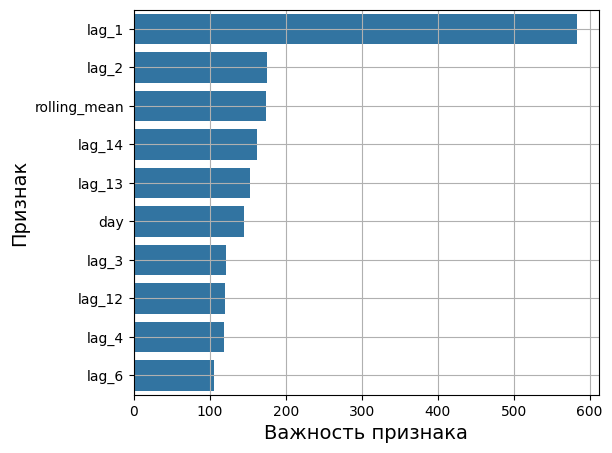

In [ ]:
# Визуализируем коэффициенты признаков
# добавляем размер графика
plt.figure(figsize=(6, 5))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])
plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

In [ ]:
# Сформируем по результатам обучения итоговую таблицу
Results = pd.DataFrame({'Model' : ['Линейная регрессия','Дерево решений', 'K ближайших соседей', 'Метод опорных векторов', 'Случайный лес', 'Градиентный бустинг, LGBM'],
                       'MSE на валидационной выборке': [mean_squared_error(y_test, pred),-dt.cv_results_['mean_test_mse'][dt.best_index_],-KNN.cv_results_['mean_test_mse'][KNN.best_index_],-svr.cv_results_['mean_test_mse'][svr.best_index_],-rantree.cv_results_['mean_test_mse'][rantree.best_index_],-lgbm.cv_results_['mean_test_mse'][lgbm.best_index_]],
                        'RMSE на валидационной выборке' : [np.sqrt(mean_squared_error(y_test, pred)),-dt.best_score_,-KNN.best_score_,-svr.best_score_,-rantree.best_score_,-lgbm.best_score_],
                        'MAE на валидационной выборке': [mean_absolute_error(y_test, pred),-dt.cv_results_['mean_test_mae'][dt.best_index_],-KNN.cv_results_['mean_test_mae'][KNN.best_index_],-svr.cv_results_['mean_test_mae'][svr.best_index_], -rantree.cv_results_['mean_test_mae'][rantree.best_index_], -lgbm.cv_results_['mean_test_mae'][lgbm.best_index_]],
                        'MAPE на валидационной выборке': [mean_absolute_percentage_error(y_test, pred),- dt.cv_results_['mean_test_mape'][dt.best_index_],- KNN.cv_results_['mean_test_mape'][KNN.best_index_],- svr.cv_results_['mean_test_mape'][svr.best_index_],- rantree.cv_results_['mean_test_mape'][rantree.best_index_],- lgbm.cv_results_['mean_test_mape'][lgbm.best_index_]],
                       'Время обучения': [end,dt.cv_results_["mean_fit_time"][dt.best_index_],KNN.cv_results_["mean_fit_time"][KNN.best_index_],svr.cv_results_["mean_fit_time"][svr.best_index_],rantree.cv_results_["mean_fit_time"][rantree.best_index_],lgbm.cv_results_["mean_fit_time"][lgbm.best_index_]]
                        })

Results

,Model,MSE на валидационной выборке,RMSE на валидационной выборке,MAE на валидационной выборке,MAPE на валидационной выборке,Время обучения
0,Линейная регрессия,8.727980,2.954315,2.190620,0.013287,0.023898
1,Дерево решений,304.070402,13.958142,10.401043,0.133313,0.036948
2,K ближайших соседей,398.006335,17.373382,13.992395,0.186743,0.006164
3,Метод опорных векторов,6.880878,2.447620,1.817211,0.021193,0.389865
4,Случайный лес,310.547778,14.176342,10.522000,0.134281,2.278383
5,"Градиентный бустинг, LGBM",337.571046,15.520546,11.774947,0.144088,0.355804


По метрике `RMSE` лучшей моделью прогнозирования стоимости акций компании можно считать модели Линейной регрессии и метод опорных векторов. Так как для модели Линейной регрессии процесс обучения проходит быстрее, то в качестве лучшей модели можем считать линейную модель.

## Проверка на тестовой выборке

In [ ]:
best_model = svr.best_estimator_
model_pred = best_model.predict(X_test)



In [ ]:
#Коэффициенты регрессии
coef = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':best_model.feature_importances_
     }).sort_values(by ='Важность',  ascending = False).head(10)
coef

AttributeError: 'SVR' object has no attribute 'feature_importances_'

<ipython-input-98-d258e2f761b2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= coef['Важность'], y = coef['Признак'], palette='Blues_r')


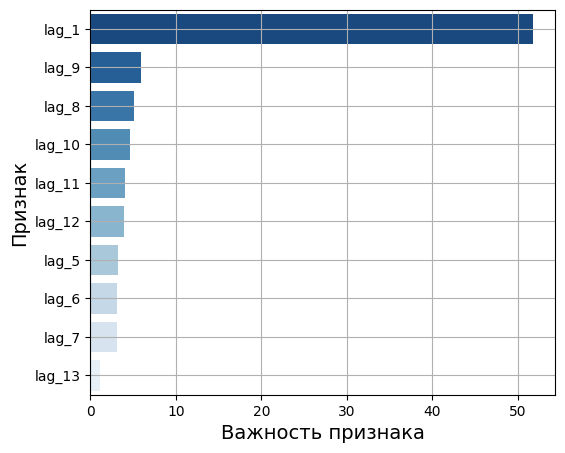

In [ ]:
# Визуализируем коэффициенты признаков
# добавляем размер графика
plt.figure(figsize=(6, 5))

sns.barplot()
plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

In [ ]:
print("MSE на тестовой выборке:",  mean_squared_error(y_test,model_pred))
print("RMSE на тестовой выборке:", np.sqrt(mean_squared_error(y_test,model_pred)))
print("MAE на тестовой выборке:", mean_absolute_error(y_test,model_pred))
print("MAPE на тестовой выборке:", mean_absolute_percentage_error(y_test,model_pred))
print("R2 на тестовой выборке:", r2_score(y_test,model_pred))

MSE на тестовой выборке: 9.262071972712846
RMSE на тестовой выборке: 3.043365238138999
MAE на тестовой выборке: 2.2763556393542523
MAPE на тестовой выборке: 0.013835265336908945
R2 на тестовой выборке: 0.9783232000547137


На тестовой выборке величина RMSE для обученной модели немного выше, чем на тренировочных данных, но величина `MAPE` составляет около 1%. Прогноз стоимости акций, построенный на основе данной модели, можно считать приемлемым.

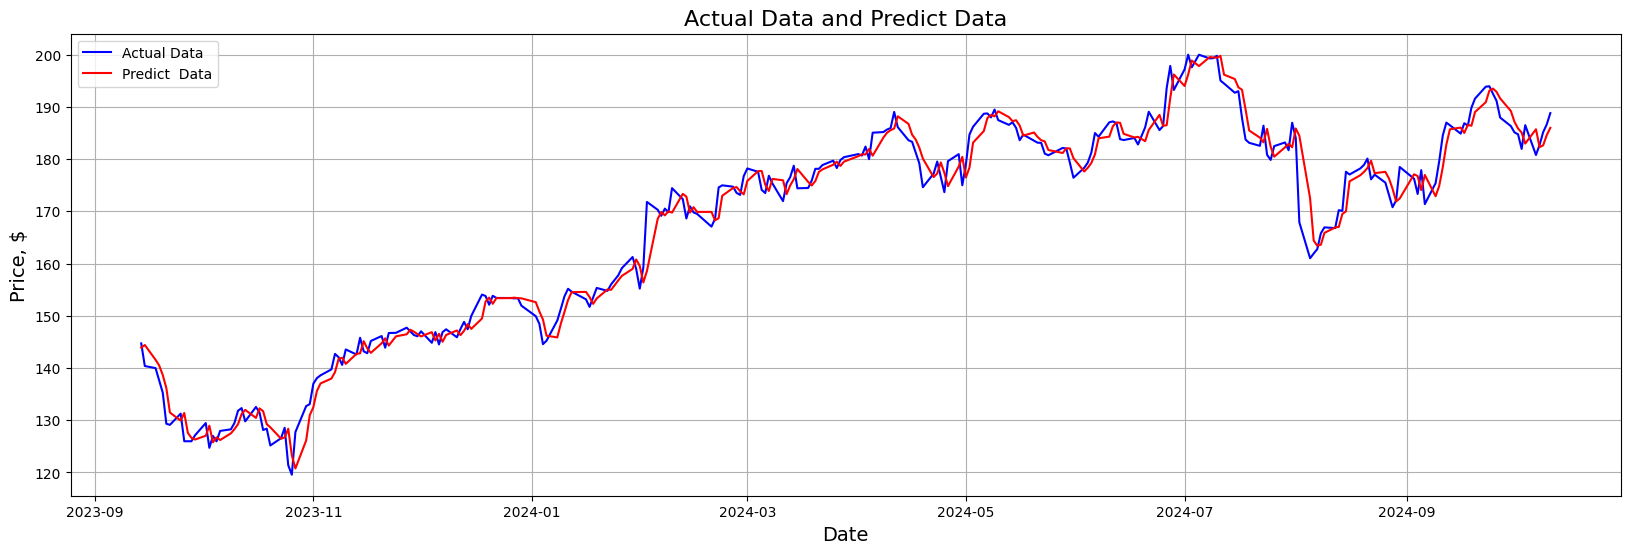

In [ ]:
# Построим графики фактических данных и результатов прогноза для тестовой выборки
plt.figure(figsize = (20, 6))
plt.plot(X_test.index, y_test, label='Actual Data', color = 'b')
plt.plot(X_test.index, model_pred, label='Predict  Data', color = 'r')
plt.legend()
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price, $', fontsize = 14)
plt.grid()
plt.title('Actual Data and Predict Data', fontsize = 16)
plt.show()

Лучшую модель стоит проверить на адекватность - для этого стоит сделать модель, предсказывающую среднее значение ряда на тренировочной выборке, оценить её качество на тестовой выборке и сравнить с качеством нашей модели - вдруг результат у константной модели, всегда предсказывающей одно и то же число, будет сопоставим или даже лучше нашей модели? Тогда стоило бы что-то поменять в процессе построения модели.
    
В качестве константной модели рекомендую использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html).

Проведем оценку адекватности построенной модели.

In [ ]:
dummy_model = DummyRegressor().fit(X_train, y_train)

In [ ]:
pred_constant = dummy_model.predict(X_test)
print("RMSE на тестовой выборке:", np.sqrt(mean_squared_error(y_test, pred_constant)))


RMSE на тестовой выборке: 86.34147495093336


Значение метрики RMSE для константной модели на тестовой выборке существенно выше значения RMSE лучшей модели. Поэтому построенную модель можно считать адекватной.